# Data Preparation

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data_path = 'timeseries_data_2024.csv'  # Replace with your actual file path
data = pd.read_csv(data_path)

# Combine date, hour, and minute columns into a single timestamp column
# Adjust format to handle cases where additional ":00" appears
try:
    data['timestamp'] = pd.to_datetime(
        data['date'] + ' ' + data['hour'],
        format='%m/%d/%y %I:%M %p'
    ) + pd.to_timedelta(data['minute'], unit='m')
except ValueError as e:
    print(f"Error parsing timestamp: {e}")
    raise

# Drop the original date, hour, and minute columns
data = data.drop(['date', 'hour', 'minute'], axis=1)

# Set the timestamp as the index
data = data.set_index('timestamp')

# Check for missing values
if data.isnull().values.any():
    print("Missing values detected. Filling missing values with forward fill.")
    data = data.fillna(method='ffill')

# Visualize data integrity (e.g., duplicate timestamps)
if data.index.duplicated().any():
    print("Duplicate timestamps found. Removing duplicates.")
    data = data[~data.index.duplicated(keep='first')]

# Split the dataset into training (80%) and testing (20%), data splitting
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# Normalize the target signals 'Ot' and 'Rt', data preprocessing
scaler = MinMaxScaler()
train_data[['Ot', 'Rt']] = scaler.fit_transform(train_data[['Ot', 'Rt']])
test_data[['Ot', 'Rt']] = scaler.transform(test_data[['Ot', 'Rt']])

# Save preprocessed data (optional)
train_data.to_csv('train_data.csv')
test_data.to_csv('test_data.csv')

print("Data preparation complete. Training and testing datasets are ready.")


Data preparation complete. Training and testing datasets are ready.


/tmp/ipykernel_3567576/2457084286.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[['Ot', 'Rt']] = scaler.fit_transform(train_data[['Ot', 'Rt']])
/tmp/ipykernel_3567576/2457084286.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[['Ot', 'Rt']] = scaler.transform(test_data[['Ot', 'Rt']])


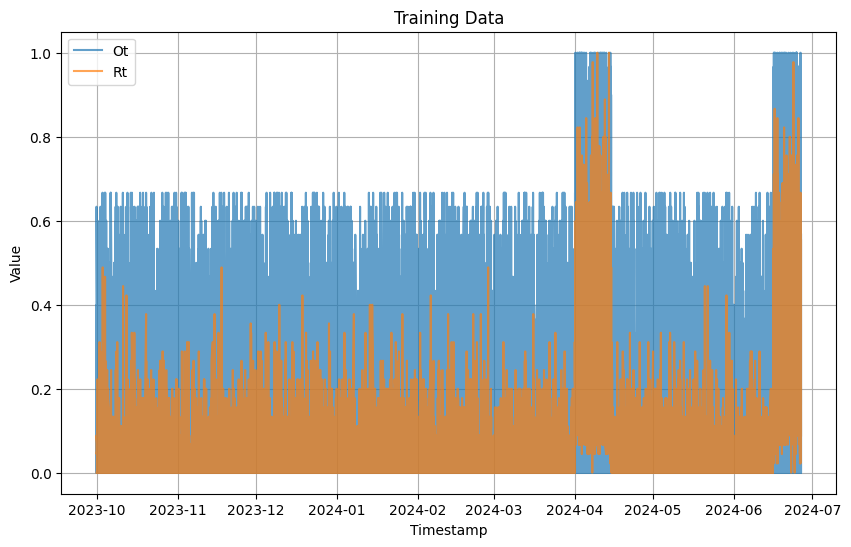

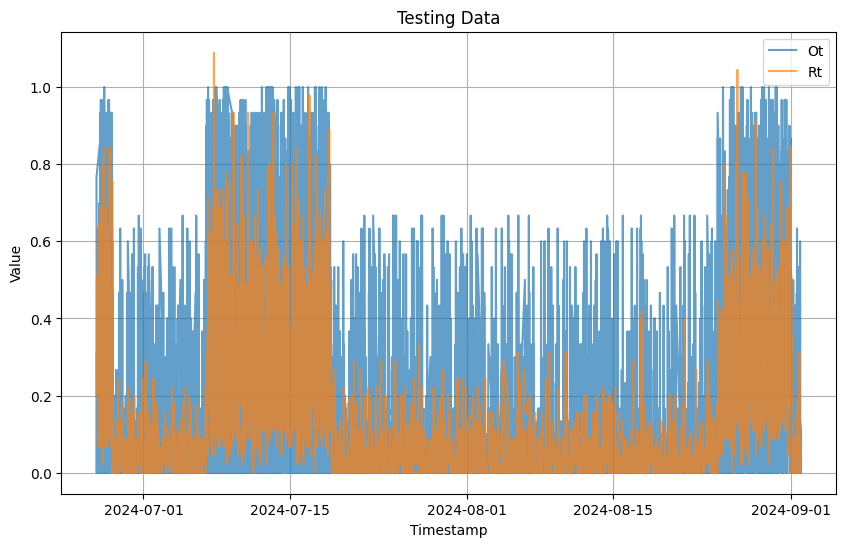

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the preprocessed data
train_data = pd.read_csv('train_data.csv', index_col='timestamp', parse_dates=True)
test_data = pd.read_csv('test_data.csv', index_col='timestamp', parse_dates=True)

# Visualize training data
def visualize_data(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Ot'], label='Ot', alpha=0.7)
    plt.plot(data.index, data['Rt'], label='Rt', alpha=0.7)
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# Visualize train_data
visualize_data(train_data, "Training Data")

# Visualize test_data
visualize_data(test_data, "Testing Data")


# Model implementation and training

## RNN Development, Training, and Evaluation

Epoch 1/100
404/404 [==============================] - 12s 25ms/step - loss: 0.6010 - val_loss: 0.0675
Epoch 2/100
404/404 [==============================] - 10s 24ms/step - loss: 0.0887 - val_loss: 0.0664
Epoch 3/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0404 - val_loss: 0.0654
Epoch 4/100
404/404 [==============================] - 10s 24ms/step - loss: 0.0366 - val_loss: 0.0609
Epoch 5/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0352 - val_loss: 0.0473
Epoch 6/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0318 - val_loss: 0.0456
Epoch 7/100
404/404 [==============================] - 10s 24ms/step - loss: 0.0300 - val_loss: 0.0454
Epoch 8/100
404/404 [==============================] - 10s 24ms/step - loss: 0.0298 - val_loss: 0.0455
Epoch 9/100
404/404 [==============================] - 10s 24ms/step - loss: 0.0298 - val_loss: 0.0520
Epoch 10/100
404/404 [==============================] - 10s 25ms/step - l

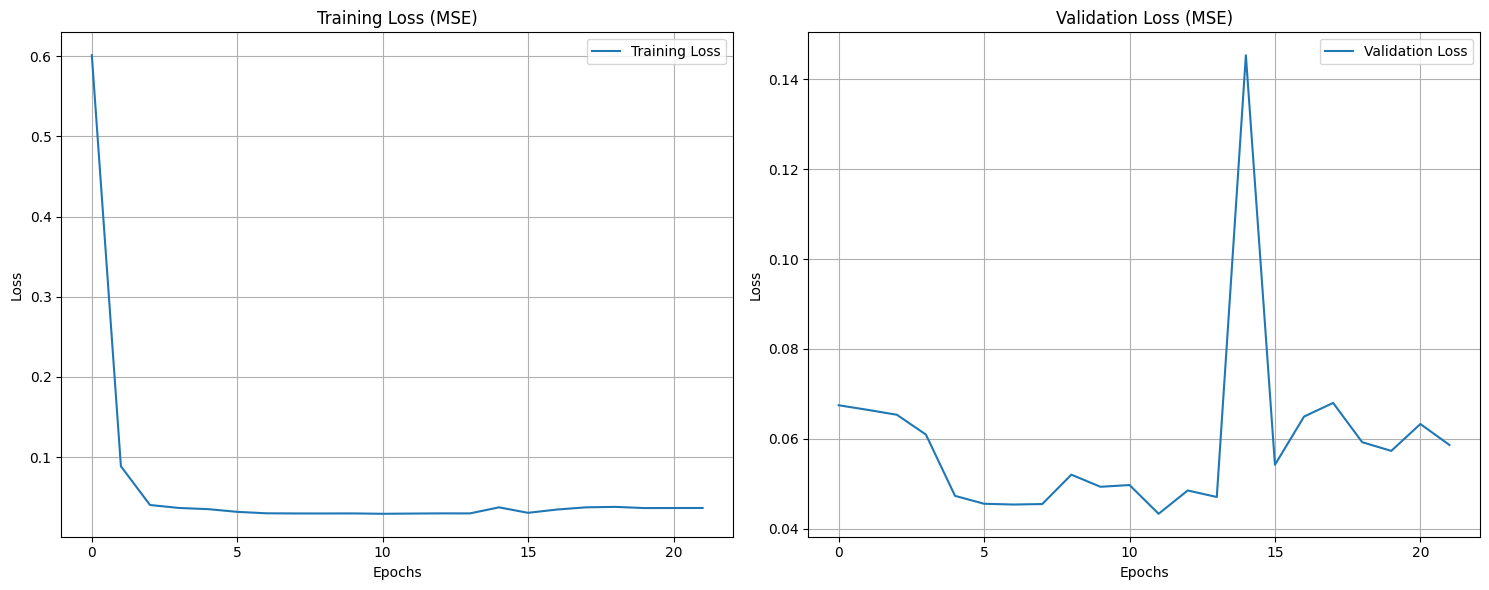

In [82]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequences(data, target_col, sequence_length):
    """
    Creates input sequences and corresponding targets for time series prediction.
    Integrates reshaping of the sequences and targets within the function.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the time series data with at least the target column.
    - target_col (str): Column name of the target variable ('Ot' in this case).
    - sequence_length (int): Number of time steps in each input sequence.

    Returns:
    - sequences_array (np.ndarray): Array of input sequences with shape (samples, sequence_length, 1).
    - targets_array (np.ndarray): Array of target values with shape (samples, 1).
    """
    sequences = []  # List to store input sequences
    targets = []    # List to store corresponding target values

    # Iterate over the data to extract sequences and targets
    for i in range(len(data) - sequence_length):
        # Extract a sequence of 'Ot' values
        seq = data[target_col].iloc[i:i + sequence_length].values
        sequences.append(seq)

        # Extract the target 'Ot' value immediately after the sequence
        target = data[target_col].iloc[i + sequence_length]
        targets.append(target)

    # Convert lists to NumPy arrays for efficient computation
    sequences_array, targets_array = np.array(sequences), np.array(targets)

    # Reshape the sequences to include the features dimension (1 feature: 'Ot')
    # New shape: (samples, sequence_length, features) => (samples, 400, 1)
    sequences_array = sequences_array.reshape(sequences_array.shape[0], sequences_array.shape[1], 1)

    # Reshape the targets to have a shape of (samples, 1) for regression
    # New shape: (samples, 1)
    targets_array = targets_array.reshape(-1, 1)

    return sequences_array, targets_array


sequence_length = 32  # Number of time steps per input sequence

# Prepare training and testing sequences
train_sequences, train_targets = create_sequences(train_data[['Ot', 'Rt']], 'Ot', sequence_length)
test_sequences, test_targets = create_sequences(test_data[['Ot', 'Rt']], 'Ot', sequence_length)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam


from tensorflow.random import set_seed

def build_deep_rnn(units, learning_rate=0.001, dropout_rate=0.2, layers=2):
    """
    Builds a deep Recurrent Neural Network (RNN) model using SimpleRNN layers.

    Parameters:
    ----------
    units : int
        Number of neurons in each SimpleRNN layer.
    learning_rate : float, default=0.001
    dropout_rate : float, default=0.2
        Fraction of the input units to drop for the Dropout layers, used for regularization.
    layers : int, default=2
        Number of stacked RNN layers in the model.

    Returns:
    -------
    model : tf.keras.Model
        Compiled Keras model ready for training.
    """
    # Set the random seed for reproducibility
    set_seed(0)
    # Initialize a Sequential model, which allows layers to be added one after another
    model = tf.keras.Sequential()
    # Loop to add the specified number of RNN layers
    for i in range(layers):
        # Determine whether to return the full sequence or only the last output
        # For all layers except the last, return_sequences should be True
        # The last RNN layer should output only the final timestep's output
        return_sequences = (i < layers - 1)
        # Add a SimpleRNN layer with the specified number of units and activation function
        # return_sequences controls the output shape for the next layer
        model.add(
            tf.keras.layers.SimpleRNN(
                units=units,
                activation='tanh',
                return_sequences=return_sequences,
                # Optionally, you can add kernel_regularizer or recurrent_regularizer here
                # to apply regularization to the weights
            )
        )
        
        # Add Batch Normalization to stabilize and accelerate training
        model.add(tf.keras.layers.BatchNormalization())        
        # Add Dropout for regularization to prevent overfitting
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    # Add a Dense layer with a single neuron for the final output
    # Suitable for regression tasks where the output is a single continuous value
    model.add(tf.keras.layers.Dense(units=1))
    # Compile the model with the Adam optimizer and Mean Squared Error loss function
    # The learning rate is set to 0.001, which is a common default value
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse'  # Mean Squared Error is appropriate for regression tasks
    )
    # Return the compiled model
    return model


# Build the enhanced Simple RNN model
rnn_model = build_deep_rnn(
    units=300,                  # Number of RNN units
    learning_rate=1e-3,        # Learning rate
    dropout_rate=0.3,          # Dropout rate
    layers=2,                  # Number of stacked RNN layers
)

# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the Simple RNN model
history = rnn_model.fit(
    train_sequences,           # Training input sequences
    train_targets,             # Training targets
    validation_data=(test_sequences, test_targets),  # Validation data
    epochs=100,                 # Number of training epochs
    batch_size=64,             # Batch size
    verbose=1,                  # Verbosity mode
    callbacks=[early_stopping_callback]  # Early Stopping callback
)

# Generate predictions on the test set
test_predictions = rnn_model.predict(test_sequences)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f"Ot Test MSE: {mse:.4f}")

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, test_predictions)
print(f"Ot Test MAE: {mae:.4f}")

# Compute R-squared (R²) Score
r2 = r2_score(test_targets, test_predictions)
print(f"Ot Test R²: {r2:.4f}")

# Create figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot for Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Second subplot for Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()





Epoch 1/100
404/404 [==============================] - 12s 25ms/step - loss: 0.5036 - val_loss: 0.1023
Epoch 2/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0346 - val_loss: 2.5030
Epoch 3/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0432 - val_loss: 0.0233
Epoch 4/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0059 - val_loss: 1.6183
Epoch 5/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0320 - val_loss: 179.8802
Epoch 6/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0311 - val_loss: 2.7673
Epoch 7/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0056 - val_loss: 0.0137
Epoch 8/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0049 - val_loss: 0.0134
Epoch 9/100
404/404 [==============================] - 10s 25ms/step - loss: 0.0047 - val_loss: 0.0171
Epoch 10/100
404/404 [==============================] - 10s 25ms/step -

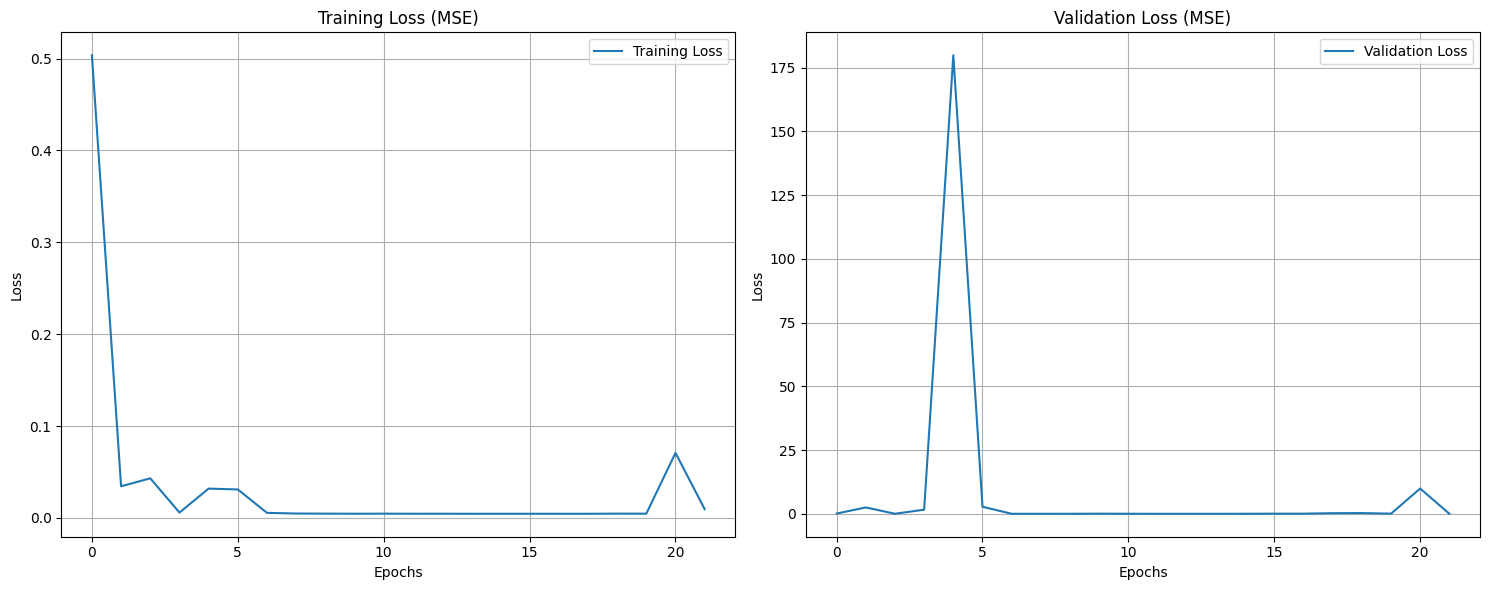

In [81]:
sequence_length = 32  # Number of time steps per input sequence

# Prepare training and testing sequences
train_sequences, train_targets = create_sequences(train_data[['Ot', 'Rt']], 'Rt', sequence_length)
test_sequences, test_targets = create_sequences(test_data[['Ot', 'Rt']], 'Rt', sequence_length)




# Build the enhanced Simple RNN model
rnn_model = build_deep_rnn(
    units=300,                  # Number of RNN units
    learning_rate=1e-3,        # Learning rate
    dropout_rate=0.3,          # Dropout rate
    layers=2,                  # Number of stacked RNN layers
)

# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the Simple RNN model
history = rnn_model.fit(
    train_sequences,           # Training input sequences
    train_targets,             # Training targets
    validation_data=(test_sequences, test_targets),  # Validation data
    epochs=100,                 # Number of training epochs
    batch_size=64,             # Batch size
    verbose=1,                  # Verbosity mode
    callbacks=[early_stopping_callback]  # Early Stopping callback
)

# Generate predictions on the test set
test_predictions = rnn_model.predict(test_sequences)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f"Rt Test MSE: {mse:.4f}")

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, test_predictions)
print(f"Rt Test MAE: {mae:.4f}")

# Compute R-squared (R²) Score
r2 = r2_score(test_targets, test_predictions)
print(f"Rt Test R²: {r2:.4f}")



# Create figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot for Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Second subplot for Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()





In [102]:
!pip install tabulate

147828.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [103]:
import pandas as pd
from tabulate import tabulate  # Optional: For better table formatting in the console

# Define the evaluation metrics
metrics = {
    'Metric': ['MSE', 'MAE', 'R²'],
    'Ot Test': [0.0433, 0.1434, 0.3599],
    'Rt Test': [0.0089,  0.0579, 0.5829]
}

# Create a DataFrame from the metrics
df = pd.DataFrame(metrics)

# Set 'Metric' as the index for better readability
df.set_index('Metric', inplace=True)

# Print the title
print("Evaluation Result of RNN\n")

# Using pandas to display the table
print(df)

Evaluation Result of RNN

        Ot Test  Rt Test
Metric                  
MSE      0.0433   0.0089
MAE      0.1434   0.0579
R²       0.3599   0.5829


## LSTM Development, Training, and Evaluation

Epoch 1/100
404/404 [==============================] - 6s 8ms/step - loss: 0.8551 - val_loss: 0.2041
Epoch 2/100
404/404 [==============================] - 3s 6ms/step - loss: 0.3071 - val_loss: 0.1715
Epoch 3/100
404/404 [==============================] - 3s 6ms/step - loss: 0.1305 - val_loss: 0.0522
Epoch 4/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0610 - val_loss: 0.0516
Epoch 5/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0360 - val_loss: 0.0442
Epoch 6/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0299 - val_loss: 0.0471
Epoch 7/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0281 - val_loss: 0.0497
Epoch 8/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0289 - val_loss: 0.0525
Epoch 9/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0293 - val_loss: 0.0531
Epoch 10/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0294 - val_lo

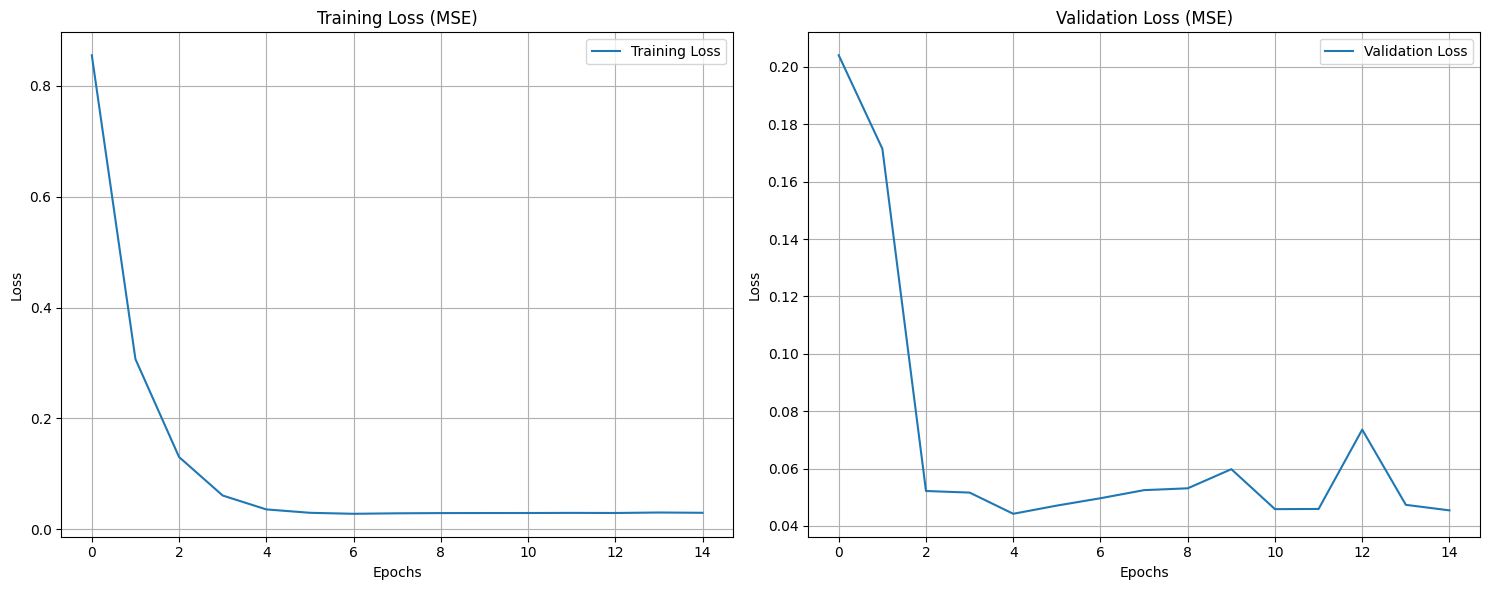

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequences(data, target_col, sequence_length):
    """
    Creates input sequences and corresponding targets for time series prediction.
    Integrates reshaping of the sequences and targets within the function.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the time series data with at least the target column.
    - target_col (str): Column name of the target variable ('Ot' in this case).
    - sequence_length (int): Number of time steps in each input sequence.

    Returns:
    - sequences_array (np.ndarray): Array of input sequences with shape (samples, sequence_length, 1).
    - targets_array (np.ndarray): Array of target values with shape (samples, 1).
    """
    sequences = []  # List to store input sequences
    targets = []    # List to store corresponding target values

    # Iterate over the data to extract sequences and targets
    for i in range(len(data) - sequence_length):
        # Extract a sequence of 'Ot' values
        seq = data[target_col].iloc[i:i + sequence_length].values
        sequences.append(seq)

        # Extract the target 'Ot' value immediately after the sequence
        target = data[target_col].iloc[i + sequence_length]
        targets.append(target)

    # Convert lists to NumPy arrays for efficient computation
    sequences_array, targets_array = np.array(sequences), np.array(targets)

    # Reshape the sequences to include the features dimension (1 feature: 'Ot')
    # New shape: (samples, sequence_length, features) => (samples, 400, 1)
    sequences_array = sequences_array.reshape(sequences_array.shape[0], sequences_array.shape[1], 1)

    # Reshape the targets to have a shape of (samples, 1) for regression
    # New shape: (samples, 1)
    targets_array = targets_array.reshape(-1, 1)

    return sequences_array, targets_array


sequence_length = 32  # Number of time steps per input sequence

# Prepare training and testing sequences
train_sequences, train_targets = create_sequences(train_data[['Ot', 'Rt']], 'Ot', sequence_length)
test_sequences, test_targets = create_sequences(test_data[['Ot', 'Rt']], 'Ot', sequence_length)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam


from tensorflow.random import set_seed

def build_deep_lstm(units, learning_rate=0.001, dropout_rate=0.2, layers=2):
    """
    Builds a deep LSTM model using LSTM layers.

    Parameters:
    ----------
    units : int
        Number of neurons in each LSTM layer.
    learning_rate : float, default=0.001
    dropout_rate : float, default=0.2
        Fraction of the input units to drop for the Dropout layers, used for regularization.
    layers : int, default=2
        Number of stacked RNN layers in the model.

    Returns:
    -------
    model : tf.keras.Model
        Compiled Keras model ready for training.
    """
    # Set the random seed for reproducibility
    set_seed(0)
    # Initialize a Sequential model, which allows layers to be added one after another
    model = tf.keras.Sequential()
    # Loop to add the specified number of RNN layers
    for i in range(layers):
        return_sequences = (i < layers - 1)
        model.add(tf.keras.layers.LSTM(units, activation='tanh', return_sequences=return_sequences))
        # Add Batch Normalization to stabilize and accelerate training
        model.add(tf.keras.layers.BatchNormalization())        
        # Add Dropout for regularization to prevent overfitting
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    # Add a Dense layer with a single neuron for the final output
    # Suitable for regression tasks where the output is a single continuous value
    model.add(tf.keras.layers.Dense(units=1))
    # Compile the model with the Adam optimizer and Mean Squared Error loss function
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse'  # Mean Squared Error is appropriate for regression tasks
    )
    # Return the compiled model
    return model


# Build the LSTM model
lstm_model = build_deep_lstm(
    units=300,                  # Number of  units
    learning_rate=1e-3,        # Learning rate
    dropout_rate=0.3,          # Dropout rate
    layers=2,                  # Number of stacked RNN layers
)

# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the LSTM model
history = lstm_model.fit(
    train_sequences,           # Training input sequences
    train_targets,             # Training targets
    validation_data=(test_sequences, test_targets),  # Validation data
    epochs=100,                 # Number of training epochs
    batch_size=64,             # Batch size
    verbose=1,                  # Verbosity mode
    callbacks=[early_stopping_callback]  # Early Stopping callback
)

# Generate predictions on the test set
test_predictions = lstm_model.predict(test_sequences)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f"Ot Test MSE: {mse:.4f}")

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, test_predictions)
print(f"Ot Test MAE: {mae:.4f}")

# Compute R-squared (R²) Score
r2 = r2_score(test_targets, test_predictions)
print(f"Ot Test R²: {r2:.4f}")

# Create figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot for Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Second subplot for Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

Epoch 1/100
404/404 [==============================] - 6s 8ms/step - loss: 0.8031 - val_loss: 0.1126
Epoch 2/100
404/404 [==============================] - 3s 6ms/step - loss: 0.2675 - val_loss: 0.0115
Epoch 3/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0864 - val_loss: 0.0090
Epoch 4/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0269 - val_loss: 0.0091
Epoch 5/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0087 - val_loss: 0.0101
Epoch 6/100
239/404 [================>.............] - ETA: 0s - loss: 0.0054

404/404 [==============================] - 3s 6ms/step - loss: 0.0051 - val_loss: 0.0086
Epoch 7/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0045 - val_loss: 0.0120
Epoch 8/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0045 - val_loss: 0.0091
Epoch 9/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0047 - val_loss: 0.0088
Epoch 10/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0046 - val_loss: 0.0098
Epoch 11/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0048 - val_loss: 0.0083
Epoch 12/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0049 - val_loss: 0.0142
Epoch 13/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0048 - val_loss: 0.0109
Epoch 14/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0048 - val_loss: 0.0086
Epoch 15/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0048 - val_loss: 0.0

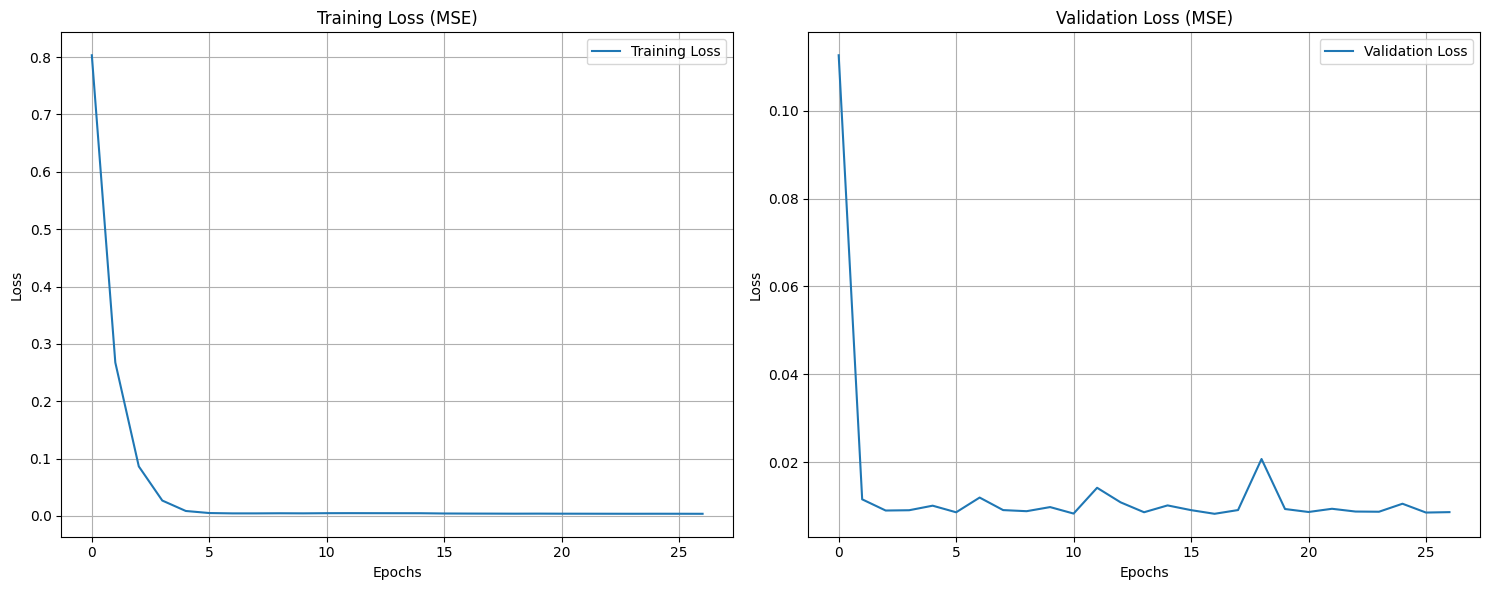

In [ ]:
sequence_length = 32  # Number of time steps per input sequence

# Prepare training and testing sequences
train_sequences, train_targets = create_sequences(train_data[['Ot', 'Rt']], 'Rt', sequence_length)
test_sequences, test_targets = create_sequences(test_data[['Ot', 'Rt']], 'Rt', sequence_length)




# Build the LSTM model
lstm_model = build_deep_lstm(
    units=300,                  # Number of LSTM units
    learning_rate=1e-3,        # Learning rate
    dropout_rate=0.3,          # Dropout rate
    layers=2,                  # Number of stacked LSTM layers
)

# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the LSTM model
history = lstm_model.fit(
    train_sequences,           # Training input sequences
    train_targets,             # Training targets
    validation_data=(test_sequences, test_targets),  # Validation data
    epochs=100,                 # Number of training epochs
    batch_size=64,             # Batch size
    verbose=1,                  # Verbosity mode
    callbacks=[early_stopping_callback]  # Early Stopping callback
)

# Generate predictions on the test set
test_predictions = lstm_model.predict(test_sequences)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f"Rt Test MSE: {mse:.4f}")

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, test_predictions)
print(f"Rt Test MAE: {mae:.4f}")

# Compute R-squared (R²) Score
r2 = r2_score(test_targets, test_predictions)
print(f"Rt Test R²: {r2:.4f}")

# Create figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot for Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Second subplot for Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()


In [104]:
import pandas as pd
from tabulate import tabulate  # Optional: For better table formatting in the console

# Define the evaluation metrics
metrics = {
    'Metric': ['MSE', 'MAE', 'R²'],
    'Ot Test': [0.0442, 0.1498, 0.3464],
    'Rt Test': [0.0134, 0.0713, 0.3699]
}

# Create a DataFrame from the metrics
df = pd.DataFrame(metrics)

# Set 'Metric' as the index for better readability
df.set_index('Metric', inplace=True)

# Print the title
print("Evaluation Result of LSTM\n")

# Using pandas to display the table
print(df)


Evaluation Result of LSTM

        Ot Test  Rt Test
Metric                  
MSE      0.0442   0.0134
MAE      0.1498   0.0713
R²       0.3464   0.3699


## GRU Development, Training, and Evaluation

Epoch 1/100
404/404 [==============================] - 6s 8ms/step - loss: 0.8603 - val_loss: 0.0689
Epoch 2/100
404/404 [==============================] - 2s 6ms/step - loss: 0.3121 - val_loss: 0.0457
Epoch 3/100
404/404 [==============================] - 2s 6ms/step - loss: 0.1205 - val_loss: 0.0461
Epoch 4/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0548 - val_loss: 0.0449
Epoch 5/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0338 - val_loss: 0.0492
Epoch 6/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0301 - val_loss: 0.0435
Epoch 7/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0288 - val_loss: 0.0472
Epoch 8/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0299 - val_loss: 0.0549
Epoch 9/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0301 - val_loss: 0.0708
Epoch 10/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0300 - val_lo

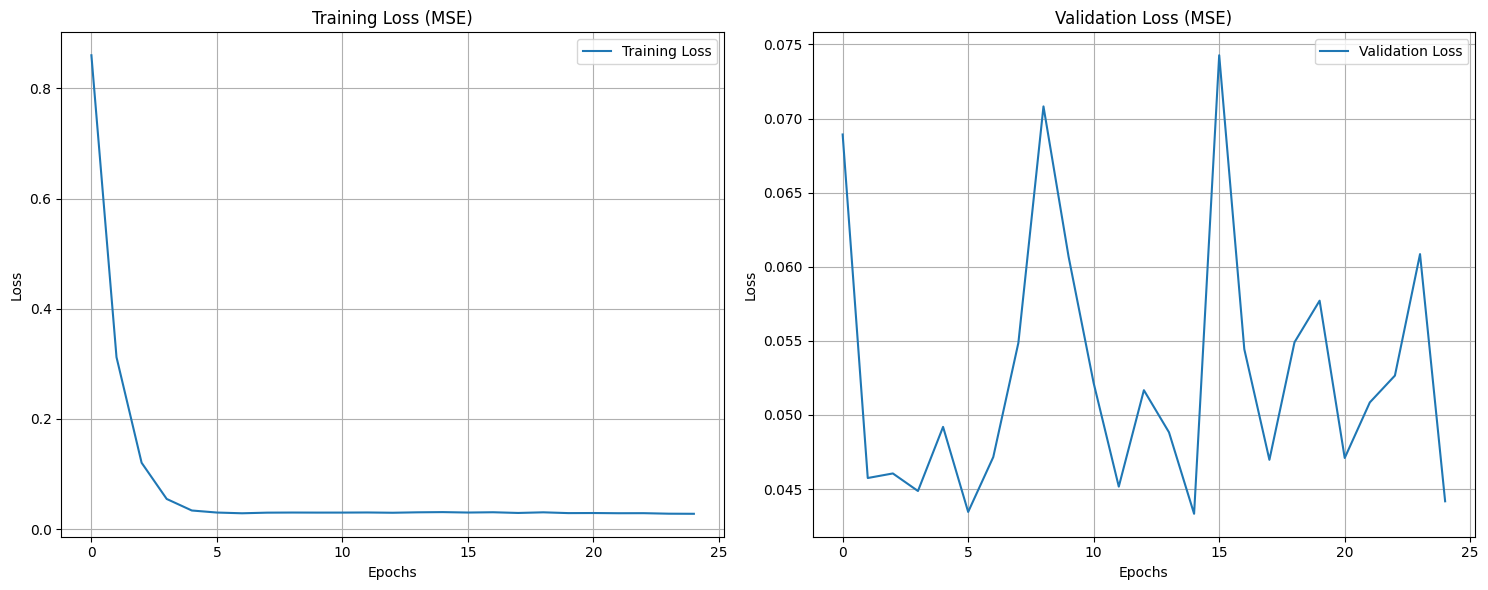

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequences(data, target_col, sequence_length):
    """
    Creates input sequences and corresponding targets for time series prediction.
    Integrates reshaping of the sequences and targets within the function.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the time series data with at least the target column.
    - target_col (str): Column name of the target variable ('Ot' in this case).
    - sequence_length (int): Number of time steps in each input sequence.

    Returns:
    - sequences_array (np.ndarray): Array of input sequences with shape (samples, sequence_length, 1).
    - targets_array (np.ndarray): Array of target values with shape (samples, 1).
    """
    sequences = []  # List to store input sequences
    targets = []    # List to store corresponding target values

    # Iterate over the data to extract sequences and targets
    for i in range(len(data) - sequence_length):
        # Extract a sequence of 'Ot' values
        seq = data[target_col].iloc[i:i + sequence_length].values
        sequences.append(seq)

        # Extract the target 'Ot' value immediately after the sequence
        target = data[target_col].iloc[i + sequence_length]
        targets.append(target)

    # Convert lists to NumPy arrays for efficient computation
    sequences_array, targets_array = np.array(sequences), np.array(targets)

    # Reshape the sequences to include the features dimension (1 feature: 'Ot')
    # New shape: (samples, sequence_length, features) => (samples, 400, 1)
    sequences_array = sequences_array.reshape(sequences_array.shape[0], sequences_array.shape[1], 1)

    # Reshape the targets to have a shape of (samples, 1) for regression
    # New shape: (samples, 1)
    targets_array = targets_array.reshape(-1, 1)

    return sequences_array, targets_array


sequence_length = 32  # Number of time steps per input sequence

# Prepare training and testing sequences
train_sequences, train_targets = create_sequences(train_data[['Ot', 'Rt']], 'Ot', sequence_length)
test_sequences, test_targets = create_sequences(test_data[['Ot', 'Rt']], 'Ot', sequence_length)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam


from tensorflow.random import set_seed



def build_deep_gru(units, learning_rate=1e-3, dropout_rate=0.2, layers=2):
    """
    Builds a deep Gate Recurrent Units (GRU) model using GRU layers.

    Parameters:
    ----------
    units : int
        Number of neurons in each GRU layer.
    dropout_rate : float, default=0.2
        Fraction of the input units to drop for the Dropout layers, used for regularization.
    layers : int, default=2
        Number of stacked RNN layers in the model.

    Returns:
    -------
    model : tf.keras.Model
        Compiled Keras model ready for training.
    """
    # Set the random seed for reproducibility
    set_seed(0)
    # Initialize a Sequential model, which allows layers to be added one after another
    model = tf.keras.Sequential()
    # Loop to add the specified number of RNN layers
    for i in range(layers):
        return_sequences = (i < layers - 1)
        model.add(tf.keras.layers.GRU(units, activation='tanh', return_sequences=return_sequences))
        # Add Batch Normalization to stabilize and accelerate training
        model.add(tf.keras.layers.BatchNormalization())        
        # Add Dropout for regularization to prevent overfitting
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    # Add a Dense layer with a single neuron for the final output
    # Suitable for regression tasks where the output is a single continuous value
    model.add(tf.keras.layers.Dense(units=1))
    # Compile the model with the Adam optimizer and Mean Squared Error loss function
    # The learning rate is set to 0.001, which is a common default value
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse'  # Mean Squared Error is appropriate for regression tasks
    )
    # Return the compiled model
    return model


# Build the GRU model
gru_model = build_deep_gru(
    units=300,                  # Number of RNN units
    learning_rate=1e-3,        # Learning rate
    dropout_rate=0.3,          # Dropout rate
    layers=2,                  # Number of stacked RNN layers
)

# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the GRU model
history = gru_model.fit(
    train_sequences,           # Training input sequences
    train_targets,             # Training targets
    validation_data=(test_sequences, test_targets),  # Validation data
    epochs=100,                 # Number of training epochs
    batch_size=64,             # Batch size
    verbose=1,                  # Verbosity mode
    callbacks=[early_stopping_callback]  # Early Stopping callback
)

# Generate predictions on the test set
test_predictions = gru_model.predict(test_sequences)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f"Ot Test MSE: {mse:.4f}")

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, test_predictions)
print(f"Ot Test MAE: {mae:.4f}")

# Compute R-squared (R²) Score
r2 = r2_score(test_targets, test_predictions)
print(f"Ot Test R²: {r2:.4f}")

# Create figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot for Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Second subplot for Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

Epoch 1/100
404/404 [==============================] - 6s 7ms/step - loss: 0.7894 - val_loss: 0.1709
Epoch 2/100
404/404 [==============================] - 3s 6ms/step - loss: 0.3131 - val_loss: 0.0112
Epoch 3/100
404/404 [==============================] - 3s 6ms/step - loss: 0.1268 - val_loss: 0.0096
Epoch 4/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0378 - val_loss: 0.0090
Epoch 5/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0118 - val_loss: 0.0089
Epoch 6/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0057 - val_loss: 0.0082
Epoch 7/100
404/404 [==============================] - 3s 6ms/step - loss: 0.0046 - val_loss: 0.0111
Epoch 8/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0043 - val_loss: 0.0088
Epoch 9/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0046 - val_loss: 0.0082
Epoch 10/100
404/404 [==============================] - 2s 6ms/step - loss: 0.0045 - val_lo

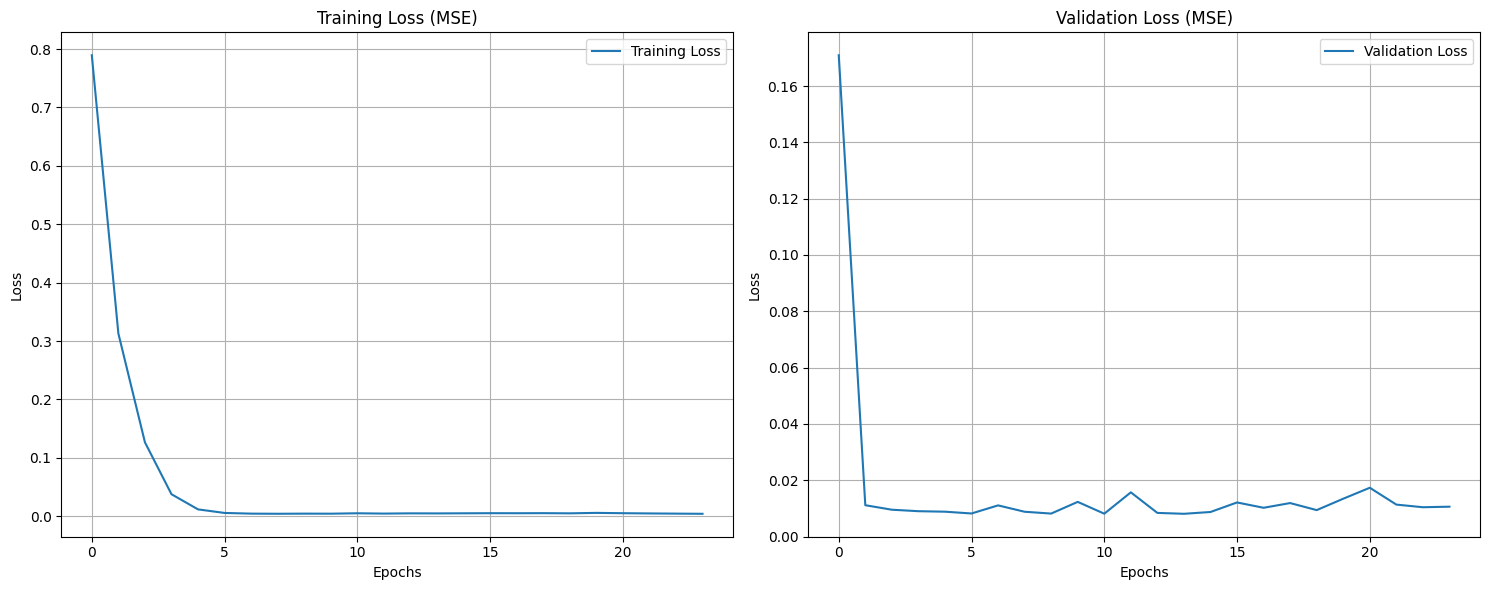

In [ ]:
sequence_length = 32  # Number of time steps per input sequence

# Prepare training and testing sequences
train_sequences, train_targets = create_sequences(train_data[['Ot', 'Rt']], 'Rt', sequence_length)
test_sequences, test_targets = create_sequences(test_data[['Ot', 'Rt']], 'Rt', sequence_length)

# Build the GRU model
gru_model = build_deep_gru(
    units=300,                  # Number of GRU units
    learning_rate=1e-3,        # Learning rate
    dropout_rate=0.3,          # Dropout rate
    layers=2,                  # Number of stacked GRU layers
)

# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the GRU model
history = gru_model.fit(
    train_sequences,           # Training input sequences
    train_targets,             # Training targets
    validation_data=(test_sequences, test_targets),  # Validation data
    epochs=100,                 # Number of training epochs
    batch_size=64,             # Batch size
    verbose=1,                  # Verbosity mode
    callbacks=[early_stopping_callback]  # Early Stopping callback
)

# Generate predictions on the test set
test_predictions = gru_model.predict(test_sequences)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f"Rt Test MSE: {mse:.4f}")

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, test_predictions)
print(f"Rt Test MAE: {mae:.4f}")

# Compute R-squared (R²) Score
r2 = r2_score(test_targets, test_predictions)
print(f"Rt Test R²: {r2:.4f}")

# Create figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot for Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Second subplot for Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()





In [105]:
import pandas as pd
from tabulate import tabulate  # Optional: For better table formatting in the console

# Define the evaluation metrics
metrics = {
    'Metric': ['MSE', 'MAE', 'R²'],
    'Ot Test': [0.0433, 0.1366, 0.3599],
    'Rt Test': [0.0081, 0.0565, 0.6179]
}

# Create a DataFrame from the metrics
df = pd.DataFrame(metrics)

# Set 'Metric' as the index for better readability
df.set_index('Metric', inplace=True)

# Print the title
print("Evaluation Result of GRU\n")

# Using pandas to display the table
print(df)

Evaluation Result of GRU

        Ot Test  Rt Test
Metric                  
MSE      0.0433   0.0081
MAE      0.1366   0.0565
R²       0.3599   0.6179


## Transformer Development, Training, and Evaluation

Epoch 1/100
404/404 [==============================] - 6s 8ms/step - loss: 1.0653 - val_loss: 0.0466
Epoch 2/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0286 - val_loss: 0.0482
Epoch 3/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0286 - val_loss: 0.0520
Epoch 4/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0289 - val_loss: 0.0447
Epoch 5/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0282 - val_loss: 0.0438
Epoch 6/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0280 - val_loss: 0.0460
Epoch 7/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0280 - val_loss: 0.0437
Epoch 8/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0276 - val_loss: 0.0433
Epoch 9/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0274 - val_loss: 0.0507
Epoch 10/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0275 - val_lo

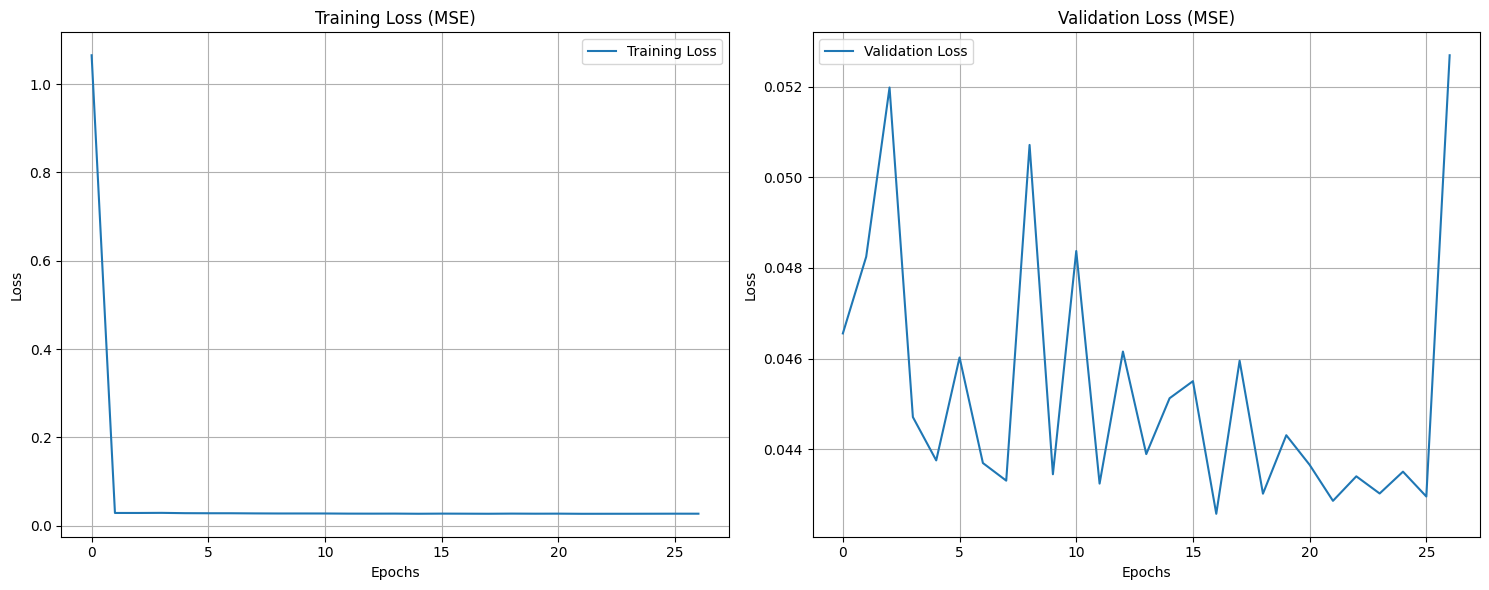

In [95]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_sequences(data, target_col, sequence_length):
    """
    Creates input sequences and corresponding targets for time series prediction.
    Integrates reshaping of the sequences and targets within the function.

    Parameters:
    - data (pd.DataFrame): DataFrame containing the time series data with at least the target column.
    - target_col (str): Column name of the target variable ('Ot' in this case).
    - sequence_length (int): Number of time steps in each input sequence.

    Returns:
    - sequences_array (np.ndarray): Array of input sequences with shape (samples, sequence_length, 1).
    - targets_array (np.ndarray): Array of target values with shape (samples, 1).
    """
    sequences = []  # List to store input sequences
    targets = []    # List to store corresponding target values

    # Iterate over the data to extract sequences and targets
    for i in range(len(data) - sequence_length):
        # Extract a sequence of 'Ot' values
        seq = data[target_col].iloc[i:i + sequence_length].values
        sequences.append(seq)

        # Extract the target 'Ot' value immediately after the sequence
        target = data[target_col].iloc[i + sequence_length]
        targets.append(target)

    # Convert lists to NumPy arrays for efficient computation
    sequences_array, targets_array = np.array(sequences), np.array(targets)

    # Reshape the sequences to include the features dimension (1 feature: 'Ot')
    # New shape: (samples, sequence_length, features) => (samples, 400, 1)
    sequences_array = sequences_array.reshape(sequences_array.shape[0], sequences_array.shape[1], 1)

    # Reshape the targets to have a shape of (samples, 1) for regression
    # New shape: (samples, 1)
    targets_array = targets_array.reshape(-1, 1)

    return sequences_array, targets_array


sequence_length = 32  # Number of time steps per input sequence

# Prepare training and testing sequences
train_sequences, train_targets = create_sequences(train_data[['Ot', 'Rt']], 'Ot', sequence_length)
test_sequences, test_targets = create_sequences(test_data[['Ot', 'Rt']], 'Ot', sequence_length)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam


from tensorflow.random import set_seed

# Define the Transformer model builder
def build_deep_transformer(num_heads, d_model, ff_units, learning_rate=1e-3, dropout_rate=0.2, layers=2, sequence_length=100):
    """
    Builds a deep Transformer model using Multi-Head Attention layers.

    Parameters:
    ----------
    num_heads : int
        Number of attention heads in each Multi-Head Attention layer.
    d_model : int
        Dimensionality of the embedding space.
    ff_units : int
        Number of units in the feed-forward network.
    learning_rate : float, default=1e-3
    dropout_rate : float, default=0.2
        Fraction of the input units to drop for the Dropout layers, used for regularization.
    layers : int, default=2
        Number of stacked Transformer encoder layers in the model.
    sequence_length : int, default=100
        Length of the input sequences. This parameter is required to compute positional encoding.

    Returns:
    -------
    model : tf.keras.Model
        Compiled Keras Transformer model ready for training.
    """
    
    class TransformerModel(tf.keras.Model):
        def __init__(self, num_heads, d_model, ff_units, layers):
            """
            Initializes the TransformerModel.

            Parameters:
            ----------
            num_heads : int
                Number of attention heads.
            d_model : int
                Dimensionality of the embedding space.
            ff_units : int
                Number of units in the feed-forward network.
            layers : int
                Number of Transformer encoder layers.
            """
            super(TransformerModel, self).__init__()
            
            # Dense layer to project input features to the desired model dimensionality
            self.embedding = tf.keras.layers.Dense(d_model)
            
            # Generate positional encoding to inject sequence order information
            self.positional_encoding = self.get_positional_encoding(sequence_length, d_model)
            
            # Create a list of Multi-Head Attention layers (Transformer encoder layers)
            self.encoder_layers = [
                tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
                for _ in range(layers)
            ]
            
            # Feed-Forward Network (FFN) comprising two Dense layers with a ReLU activation and Dropout
            self.ffn = tf.keras.Sequential([
                tf.keras.layers.Dense(ff_units, activation='relu'),  # First Dense layer with ReLU activation
                tf.keras.layers.Dropout(dropout_rate),               # Dropout layer for regularization
                tf.keras.layers.Dense(d_model)                       # Second Dense layer projecting back to d_model
            ])
            
            # Final output layer projecting to a single value (suitable for regression tasks)
            self.output_layer = tf.keras.layers.Dense(1)

        def get_positional_encoding(self, seq_len, d_model):
            """
            Generates positional encoding for input sequences.

            Parameters:
            ----------
            seq_len : int
                Length of the input sequences.
            d_model : int
                Dimensionality of the embedding space.

            Returns:
            -------
            positional_encoding : tf.Tensor
                Tensor containing positional encodings.
            """
            # Create position indices (shape: [seq_len, 1])
            positions = np.arange(seq_len)[:, np.newaxis]
            
            # Create dimension indices (shape: [1, d_model])
            dimensions = np.arange(d_model)[np.newaxis, :]
            
            # Compute the angles for sine and cosine functions
            angles = positions / np.power(10000, (2 * (dimensions // 2)) / np.float32(d_model))
            
            # Initialize positional encoding matrix
            positional_encoding = np.zeros_like(angles)
            
            # Apply sine to even indices in the array
            positional_encoding[:, 0::2] = np.sin(angles[:, 0::2])
            
            # Apply cosine to odd indices in the array
            positional_encoding[:, 1::2] = np.cos(angles[:, 1::2])
            
            # Convert to TensorFlow tensor with dtype float32
            return tf.cast(positional_encoding, dtype=tf.float32)

        def call(self, inputs, training=False):
            """
            Forward pass of the TransformerModel.

            Parameters:
            ----------
            inputs : tf.Tensor
                Input tensor with shape (batch_size, sequence_length, feature_dim).
            training : bool, default=False
                Indicates whether the call is in training mode (enables Dropout).

            Returns:
            -------
            output : tf.Tensor
                Output tensor with shape (batch_size, 1).
            """
            # Project input features to d_model dimensions and add positional encoding
            x = self.embedding(inputs) + self.positional_encoding  # Shape: (batch_size, seq_len, d_model)
            
            # Pass through each Transformer encoder layer
            for attention_layer in self.encoder_layers:
                # Apply Multi-Head Attention (self-attention)
                attention_output = attention_layer(query=x, value=x, key=x)  # Shape: (batch_size, seq_len, d_model)
                
                # Add & Normalize (Residual connection is implicitly handled in this simplified version)
                x = attention_output + x  # Residual connection
                
                # Apply Feed-Forward Network
                ffn_output = self.ffn(x, training=training)  # Shape: (batch_size, seq_len, d_model)
                
                # Add & Normalize (Residual connection)
                x = ffn_output + x  # Residual connection
            
            # Global average pooling over the sequence length dimension
            x = tf.reduce_mean(x, axis=1)  # Shape: (batch_size, d_model)
            
            # Final output layer to produce the prediction
            output = self.output_layer(x)  # Shape: (batch_size, 1)
            
            return output

    # Instantiate the TransformerModel with the provided parameters
    model = TransformerModel(num_heads, d_model, ff_units, layers)
    
    # Compile the model with Adam optimizer and Mean Squared Error loss (suitable for regression)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),  # Adam optimizer with specified learning rate
        loss='mse'  # Mean Squared Error loss function
    )
    
    # Return the compiled model
    return model

# Build the Transformer model
num_heads = 4          # Number of attention heads
d_model = 128          # Embedding dimensionality
ff_units = 3072         # Number of units in the feed-forward network
learning_rate = 1e-3   # Learning rate for the Adam optimizer
dropout_rate = 0.3     # Dropout rate to prevent overfitting
layers = 2             # Number of stacked Transformer encoder layers


# Build the Transformer model
transformer_model = build_deep_transformer(
    num_heads=num_heads,
    d_model=d_model,
    ff_units=ff_units,
    learning_rate=learning_rate,
    dropout_rate=dropout_rate,
    layers=layers,
    sequence_length=sequence_length
)

# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the GRU model
history = transformer_model.fit(
    train_sequences,           # Training input sequences
    train_targets,             # Training targets
    validation_data=(test_sequences, test_targets),  # Validation data
    epochs=100,                 # Number of training epochs
    batch_size=64,             # Batch size
    verbose=1,                  # Verbosity mode
    callbacks=[early_stopping_callback]  # Early Stopping callback
)

# Generate predictions on the test set
test_predictions = transformer_model.predict(test_sequences)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f"Ot Test MSE: {mse:.4f}")

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, test_predictions)
print(f"Ot Test MAE: {mae:.4f}")

# Compute R-squared (R²) Score
r2 = r2_score(test_targets, test_predictions)
print(f"Ot Test R²: {r2:.4f}")

# Create figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot for Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Second subplot for Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

Epoch 1/100
404/404 [==============================] - 6s 8ms/step - loss: 0.8624 - val_loss: 0.0107
Epoch 2/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0054 - val_loss: 0.0105
Epoch 3/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0052 - val_loss: 0.0094
Epoch 4/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0049 - val_loss: 0.0088
Epoch 5/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0047 - val_loss: 0.0084
Epoch 6/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0043 - val_loss: 0.0086
Epoch 7/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0042 - val_loss: 0.0134
Epoch 8/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0042 - val_loss: 0.0097
Epoch 9/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0040 - val_loss: 0.0087
Epoch 10/100
404/404 [==============================] - 3s 7ms/step - loss: 0.0041 - val_lo

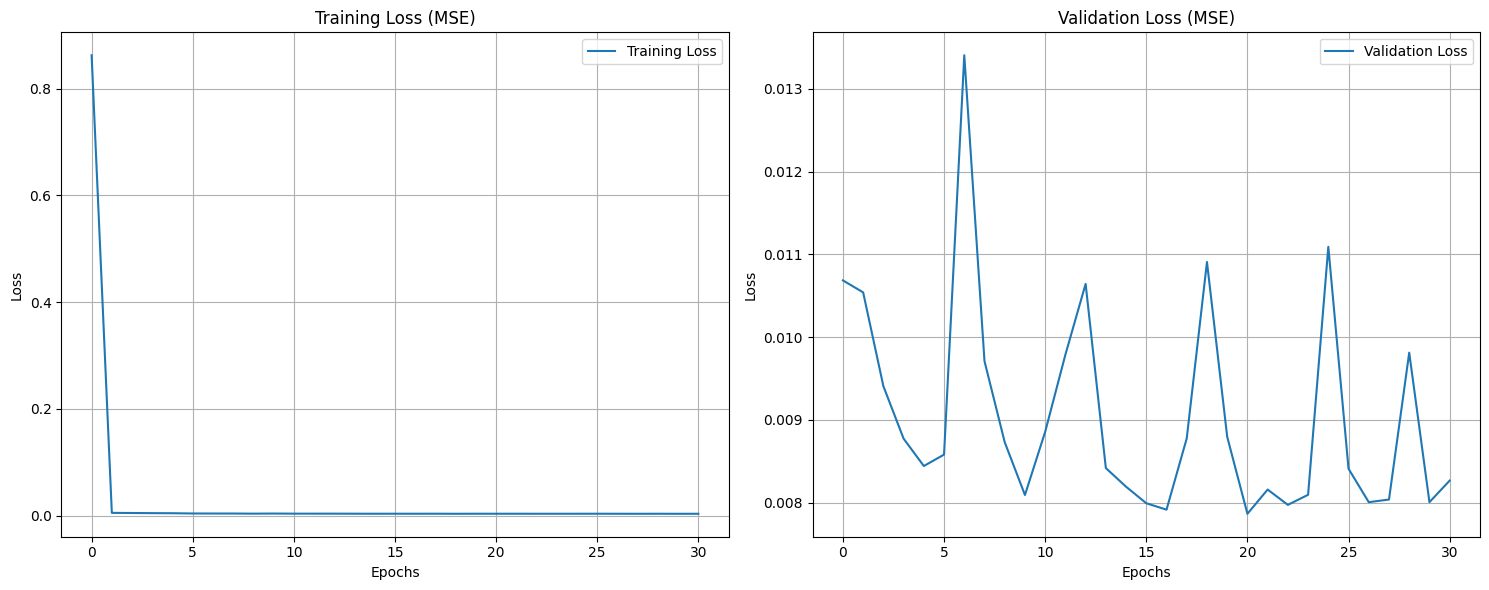

In [ ]:
sequence_length = 32  # Number of time steps per input sequence

# Prepare training and testing sequences
train_sequences, train_targets = create_sequences(train_data[['Ot', 'Rt']], 'Rt', sequence_length)
test_sequences, test_targets = create_sequences(test_data[['Ot', 'Rt']], 'Rt', sequence_length)

num_heads = 4          # Number of attention heads
d_model = 128          # Embedding dimensionality
ff_units = 3072         # Number of units in the feed-forward network
learning_rate = 1e-3   # Learning rate for the Adam optimizer
dropout_rate = 0.3     # Dropout rate to prevent overfitting
layers = 2             # Number of stacked Transformer encoder layers


# Build the Transformer model
transformer_model = build_deep_transformer(
    num_heads=num_heads,
    d_model=d_model,
    ff_units=ff_units,
    learning_rate=learning_rate,
    dropout_rate=dropout_rate,
    layers=layers,
    sequence_length=sequence_length
)

# Early Stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the Transformer model
history = transformer_model.fit(
    train_sequences,           # Training input sequences
    train_targets,             # Training targets
    validation_data=(test_sequences, test_targets),  # Validation data
    epochs=100,                 # Number of training epochs
    batch_size=64,             # Batch size
    verbose=1,                  # Verbosity mode
    callbacks=[early_stopping_callback]  # Early Stopping callback
)

# Generate predictions on the test set
test_predictions = transformer_model.predict(test_sequences)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(test_targets, test_predictions)
print(f"Rt Test MSE: {mse:.4f}")

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(test_targets, test_predictions)
print(f"Rt Test MAE: {mae:.4f}")

# Compute R-squared (R²) Score
r2 = r2_score(test_targets, test_predictions)
print(f"Rt Test R²: {r2:.4f}")

# Create figure with two subplots
plt.figure(figsize=(15, 6))

# First subplot for Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Second subplot for Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid for better readability
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()





In [106]:
import pandas as pd
from tabulate import tabulate  # Optional: For better table formatting in the console

# Define the evaluation metrics
metrics = {
    'Metric': ['MSE', 'MAE', 'R²'],
    'Ot Test': [0.0426, 0.1495, 0.3711],
    'Rt Test': [0.0079,  0.0521, 0.6293]
}

# Create a DataFrame from the metrics
df = pd.DataFrame(metrics)

# Set 'Metric' as the index for better readability
df.set_index('Metric', inplace=True)

# Print the title
print("Evaluation Result of Transformer\n")

# Using pandas to display the table
print(df)

Evaluation Result of Transformer

        Ot Test  Rt Test
Metric                  
MSE      0.0426   0.0079
MAE      0.1495   0.0521
R²       0.3711   0.6293


## Table Summarizing the evaluation metrics (MSE, MAE, and R^2) for each model on the testing data

In [107]:
import pandas as pd
from tabulate import tabulate  # Optional: For better table formatting in the console

# Define the evaluation metrics
metrics = ['MSE', 'MAE', 'R²']

# Define the evaluation results for each model
evaluation_data = {
    'Transformer': {
        'Ot Test': [0.0426, 0.1495, 0.3711],
        'Rt Test': [0.0079, 0.0521, 0.6293],
    },
    'GRU': {
        'Ot Test': [0.0433, 0.1366, 0.3599],
        'Rt Test': [0.0081, 0.0565, 0.6179],
    },
    'LSTM': {
        'Ot Test': [0.0442, 0.1498, 0.3464],
        'Rt Test': [0.0134, 0.0713, 0.3699],
    },
    'RNN': {
        'Ot Test': [0.0433, 0.1434, 0.3599],
        'Rt Test': [0.0089, 0.0579, 0.5829],
    }
}

# Create a MultiIndex for columns (Model and Test Type)
models = list(evaluation_data.keys())
tests = ['Ot Test', 'Rt Test']
column_tuples = [(model, test) for model in models for test in tests]
multi_index = pd.MultiIndex.from_tuples(column_tuples, names=['Model', 'Test Type'])

# Initialize the DataFrame with metrics as the index
comparison_df = pd.DataFrame(index=metrics, columns=multi_index)

# Populate the DataFrame with the evaluation results
for model, test_results in evaluation_data.items():
    for test, values in test_results.items():
        comparison_df[(model, test)] = values

# Optionally, convert data types to float for proper formatting
comparison_df = comparison_df.astype(float)

# Display the comparison table
print("Comparison of Evaluation Metrics for RNN, LSTM, GRU, and Transformer\n")

# Using pandas to display the table
print(comparison_df)

# Optional: Using tabulate for better formatting
# Uncomment the following lines if you prefer a prettier table in the console

# print("\nComparison of Evaluation Metrics for RNN, LSTM, GRU, and Transformer\n")
# print(tabulate(comparison_df, headers='keys', tablefmt='fancy_grid'))


Comparison of Evaluation Metrics for RNN, LSTM, GRU, and Transformer

Model     Transformer             GRU            LSTM             RNN        
Test Type     Ot Test Rt Test Ot Test Rt Test Ot Test Rt Test Ot Test Rt Test
MSE            0.0426  0.0079  0.0433  0.0081  0.0442  0.0134  0.0433  0.0089
MAE            0.1495  0.0521  0.1366  0.0565  0.1498  0.0713  0.1434  0.0579
R²             0.3711  0.6293  0.3599  0.6179  0.3464  0.3699  0.3599  0.5829


# Hyparameter tuning

In [100]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the preprocessed data
train_data = pd.read_csv('train_data.csv', index_col='timestamp', parse_dates=True)
test_data = pd.read_csv('test_data.csv', index_col='timestamp', parse_dates=True)

# Training and finetuning process for both Ot and Rt
def train_and_evaluate(target_col):
    # Prepare sequences for the target column
    train_sequences, train_targets = create_sequences(train_data[['Ot', 'Rt']], target_col, sequence_length)
    test_sequences, test_targets = create_sequences(test_data[['Ot', 'Rt']], target_col, sequence_length)

    # Define parameter grids for all models
    param_grids = [
        ('GRU', build_deep_gru, [
            {'units': units, 'learning_rate': learning_rate, 'dropout_rate': dropout_rate, 'layers': layers}
            for units in [250, 350]
            for learning_rate in [1e-4, 0.5*1e-4, 1e-5]
            for dropout_rate in [0.3]
            for layers in [2, 3]
        ]),
        ('LSTM', build_deep_lstm, [
            {'units': units, 'learning_rate': learning_rate, 'dropout_rate': dropout_rate, 'layers': layers}
            for units in [250, 350]
            for learning_rate in [1e-4, 0.5*1e-4, 1e-5]
            for dropout_rate in [0.3]
            for layers in [2, 3]
        ]),
        ('RNN', build_deep_rnn, [
            {'units': units, 'learning_rate': learning_rate, 'dropout_rate': dropout_rate, 'layers': layers}
            for units in [250, 350]
            for learning_rate in [1e-4, 0.5*1e-4, 1e-5]
            for dropout_rate in [0.3]
            for layers in [2, 3]
        ]),
        ('Transformer', build_deep_transformer, [
            {'num_heads': num_heads, 'd_model': d_model, 'ff_units': ff_units, 'learning_rate': learning_rate,'dropout_rate': dropout_rate, 'layers': layers, 'sequence_length': sequence_length}
            for num_heads in [2, 4]
            for d_model in [128, 256]
            for ff_units in [2024, 3072]
            for learning_rate in [1e-4, 0.5*1e-4, 1e-5]
            for dropout_rate in [0.3]
            for layers in [2, 3]
            for sequence_length in [32]
        ])
    ]

    best_mse = float('inf')
    best_model = None
    best_model_type = None
    best_params = None

    for model_type, build_function, param_grid in param_grids:
        print(f"Tuning {model_type} for {target_col}...")
        for params in param_grid:
            print(f"Testing with parameters: {params}")
            model = build_function(**params)
            early_stopping_callback = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True
            )

            history = model.fit(
                train_sequences, train_targets,
                validation_data=(test_sequences, test_targets),
                epochs=100,
                batch_size=64,
                callbacks=[early_stopping_callback],
                verbose=0
            )

            test_predictions = model.predict(test_sequences)
            mse = mean_squared_error(test_targets, test_predictions)
            print(f"MSE: {mse}")

            if mse < best_mse:
                best_mse = mse
                best_model = model
                best_model_type = model_type
                best_params = params

    print(f"Best Model Type for {target_col}: {best_model_type}, Best Parameters: {best_params}, Best MSE: {best_mse}")
    return best_model, best_model_type, best_params, best_mse

# Train and evaluate for both Ot and Rt
print("Training for Ot")
best_model_ot, best_model_type_ot, best_params_ot, best_mes_ot = train_and_evaluate('Ot')

print("Training for Rt")
best_model_rt, best_model_type_rt, best_params_rt, best_mse_rt = train_and_evaluate('Rt')

print("Training Complete")

Training for Ot
Tuning GRU for Ot...
Testing with parameters: {'units': 250, 'learning_rate': 0.0001, 'dropout_rate': 0.3, 'layers': 2}
202/202 [==============================] - 1s 2ms/step
MSE: 0.04281389399844391
Testing with parameters: {'units': 250, 'learning_rate': 0.0001, 'dropout_rate': 0.3, 'layers': 3}
202/202 [==============================] - 1s 3ms/step
MSE: 0.042409111350729306
Testing with parameters: {'units': 250, 'learning_rate': 5e-05, 'dropout_rate': 0.3, 'layers': 2}
202/202 [==============================] - 1s 3ms/step
MSE: 0.047706973166628204
Testing with parameters: {'units': 250, 'learning_rate': 5e-05, 'dropout_rate': 0.3, 'layers': 3}
202/202 [==============================] - 1s 3ms/step
MSE: 0.042249800961202344
Testing with parameters: {'units': 250, 'learning_rate': 1e-05, 'dropout_rate': 0.3, 'layers': 2}
202/202 [==============================] - 1s 3ms/step
MSE: 0.044131752416239595
Testing with parameters: {'units': 250, 'learning_rate': 1e-05, 'dr

In [108]:
print("Best Model for Ot:"+best_model_type_ot)
print(f"Best parameters for Ot:{best_params_ot}")
print(f"Best MSE for Ot:{best_mes_ot}")
print("Best Model for Rt: "+best_model_type_rt)
print(f"Best parameters for Rt: {best_params_rt}")
print(f"Best MSE for Rt: {best_mse_rt}")

Best Model for Ot:LSTM
Best parameters for Ot:{'units': 250, 'learning_rate': 0.0001, 'dropout_rate': 0.3, 'layers': 3}
Best MSE for Ot:0.04223466152659251
Best Model for Rt: LSTM
Best parameters for Rt: {'units': 250, 'learning_rate': 5e-05, 'dropout_rate': 0.3, 'layers': 3}
Best MSE for Rt: 0.007596707092654956
